In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from keras import layers

2023-01-12 14:21:50.003735: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-12 14:21:50.593256: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/marc/Studium/WS22-23/Database Systems/dbsys22/build/debug/mutable/src/Mutable/lib:/usr/local/boost_1_80_0/stage/lib
2023-01-12 14:21:50.593278: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-12 14:21:52.484091: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64]

In [51]:
data_file = '../../../data/RoughContact/pulloff4AIlabelled.csv'

column_names = ['Hurst', 'L', 'LambdaR', 'LambdaS', 'surfaceEnergy', 'rho', 'pulloff']

dataset = pd.read_csv(data_file)

# Hurst doesn't have any meaning at the moment, so it can be dropped
dataset.pop('Hurst')

# scaling pulloff Force
dataset  = dataset.apply(lambda x: 1_000_000*x if x.name == 'pulloff' else x)

dataset

,L,lambdaR,lambdaS,surfaceEnergy,rho,pulloff
0,512,256,4,0.008652,0.037603,0.402
1,512,256,4,0.017304,0.059691,1.000
2,512,256,4,0.034609,0.094753,2.800
3,512,256,4,0.060566,0.137601,6.760
4,512,256,4,0.112480,0.207899,29.400
...,...,...,...,...,...,...
91,1024,128,2,0.951758,0.863281,23723.700
92,1024,128,2,1.384375,1.108248,48289.200
93,1024,128,2,1.990039,1.411591,82728.200
94,1024,128,2,2.768750,1.759234,119272.500


In [52]:
train_dataset = dataset.sample(frac=0.85, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

len(train_dataset)

82

In [53]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('pulloff')
test_labels = test_features.pop('pulloff')

In [54]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
L,618.146341,208.834220
lambdaR,156.097561,53.307311
lambdaS,2.695122,1.214003
surfaceEnergy,0.970121,1.503533
rho,0.746701,0.817971
pulloff,40354.800768,78233.480237


In [55]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[[618.1463     156.09756      2.6951218    0.9701207    0.74670064]]


In [65]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.BatchNormalization(),
      layers.Dropout(0.5),
      layers.Dense(128, activation='relu'),
      layers.BatchNormalization(),
      layers.Dropout(0.5),
      layers.Dense(64, activation='relu'),
      layers.BatchNormalization(),
      layers.Dropout(0.5),
      layers.Dense(1)
  ])

  model.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(5e-3))
  return model

In [66]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 5)                11        
 ion)                                                            
                                                                 
 dense_36 (Dense)            (None, 64)                384       
                                                                 
 batch_normalization_27 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dropout_27 (Dropout)        (None, 64)                0         
                                                                 
 dense_37 (Dense)            (None, 128)               8320      
                                                                 
 batch_normalization_28 (Bat  (None, 128)             

In [67]:
batch_size = len(train_dataset) - (int) (len(train_dataset) * 0.2)

history = dnn_model.fit(
    train_features,
    train_labels,
    batch_size=batch_size,
    validation_split=0.2,
    epochs=6500)

Epoch 1/6500


/home/marc/.local/lib/python3.10/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


1/1 [==============================] - 2s 2s/step - loss: 38072.7773 - val_loss: 49080.2578
Epoch 2/6500
1/1 [==============================] - 0s 35ms/step - loss: 38072.9883 - val_loss: 49080.1992
Epoch 3/6500
1/1 [==============================] - 0s 35ms/step - loss: 38072.5547 - val_loss: 49080.1406
Epoch 4/6500
1/1 [==============================] - 0s 36ms/step - loss: 38072.3906 - val_loss: 49080.0703
Epoch 5/6500
1/1 [==============================] - 0s 35ms/step - loss: 38072.6758 - val_loss: 49080.0000
Epoch 6/6500
1/1 [==============================] - 0s 39ms/step - loss: 38072.3984 - val_loss: 49079.9297
Epoch 7/6500
1/1 [==============================] - 0s 39ms/step - loss: 38072.3242 - val_loss: 49079.8711
Epoch 8/6500
1/1 [==============================] - 0s 38ms/step - loss: 38072.4375 - val_loss: 49079.8086
Epoch 9/6500
1/1 [==============================] - 0s 37ms/step - loss: 38072.6992 - val_loss: 49079.7539
Epoch 10/6500
1/1 [==============================] -

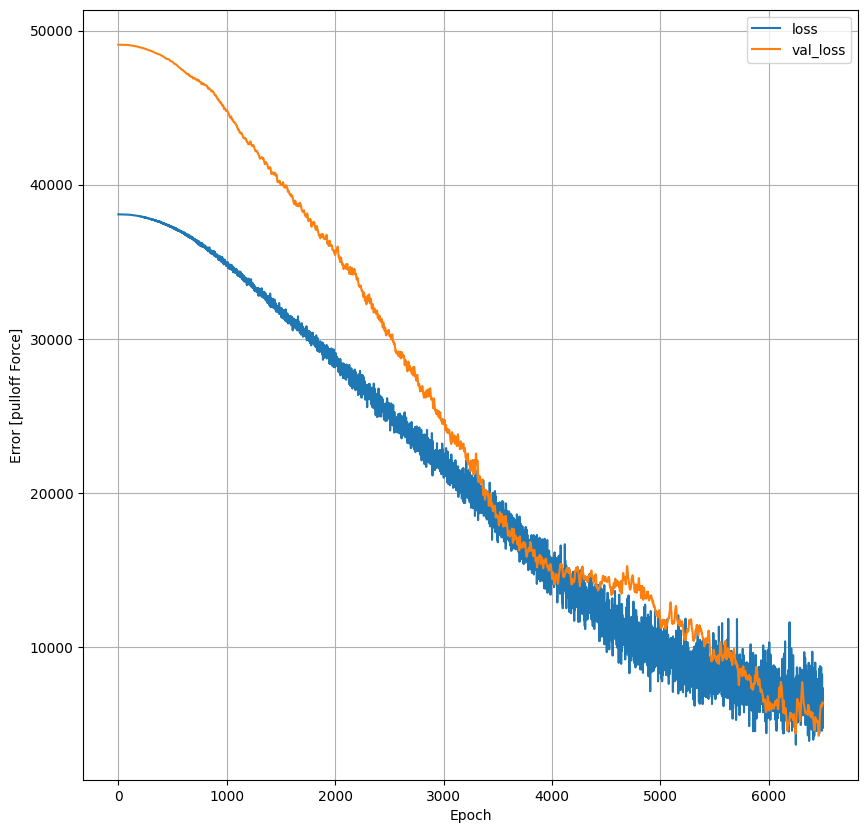

In [68]:
def plot_loss(history):
  plt.figure(figsize=(10,10))
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [pulloff Force]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

1/1 [==============================] - 0s 100ms/step


[]

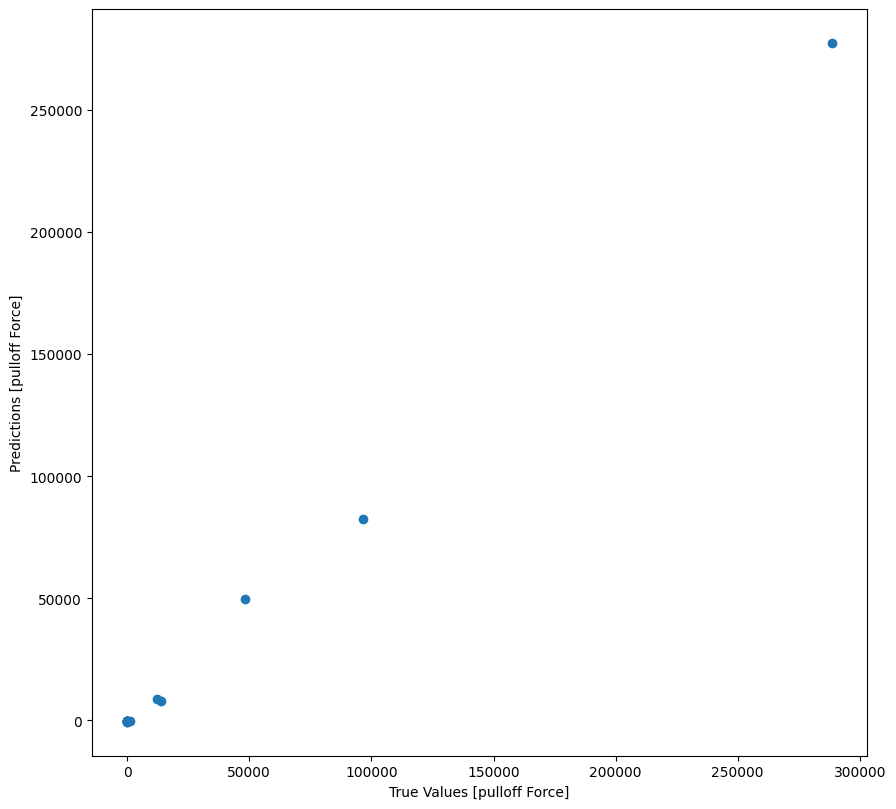

In [69]:
test_predictions = dnn_model.predict(test_features).flatten()

plt.figure(figsize=(10,10))
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [pulloff Force]')
plt.ylabel('Predictions [pulloff Force]')
plt.plot()

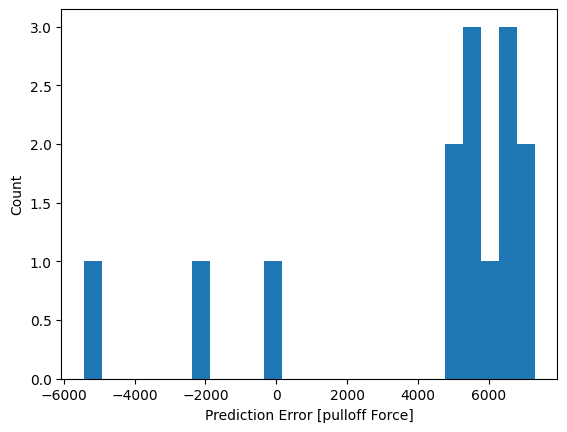

In [61]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [pulloff Force]')
_ = plt.ylabel('Count')